In [6]:
import numpy as np
import pandas as pd
import datetime
import time
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

class DemandFile:
    def __init__(self,filename, parsesheet):
        self.dataframe = importExcelData(filename, parsesheet)
        self.date = self.dataframe['Date']
        self.date_ud = unduplicate(self.date)
        self.CusID = self.dataframe['CustomerID']
        self.CusID_ud = unduplicate(self.CusID) #unduplicated customer ID list for search
    def getDataframeAll(self):
        return self.dataframe
    def getDate(self):
        return self.date
    def getCusID(self):
        return self.CusID
    def getCusID_ud(self):
        return self.CusID_ud
    def getDate_ud(self):
        return self.date_ud
def importExcelData(filename,sheet):
    xls = pd.ExcelFile(filename)
    dataframe = xls.parse(sheet)
    return dataframe
def date2str(timestamp):
    date_str = timestamp.strftime("%Y-%m-%d %H:%M:%S")
    date_str_short = timestamp.strftime("%Y-%m-%d")
    return date_str, date_str_short
def str2date(timestr):
    ifshort = False
    date_str = ""
    date_str_short = ""
    if len(timestr) < 15:
        date_str_short = timestr
        ifshort = True
    else:
        date_str = timestr
        ifshort = False
    #print ifshort
    if ifshort:
        dt_obj = pd.Timestamp(datetime.datetime.strptime(date_str_short, "%Y-%m-%d"))
    else:
        dt_obj = pd.Timestamp(datetime.datetime.strptime(date_str, "%Y-%m-%d %H:%M:%S"))
    return dt_obj
def unduplicate(listname):
    ud_list = list(set(listname))
    ud_list.sort()
    return ud_list
def inlist(dm,CLT):
    idbase = (dm['CustomerID'] == 0)
    for ind in CLT:
        tmpid = (dm['CustomerID'] == ind)
        idbase = idbase | tmpid
    return idbase
def rateCal(mlist):
    ori = np.mean(mlist[:-1])
    new = mlist[-1]
    rate = (ori - new)/ori
    return rate

In [8]:
## create DemandFile object, get basic date from it, date, date_ud, cusid, cusid_ud, and dataframe
Demandbase = DemandFile('data_10_households.xlsx', 'data_10_households')
Date = Demandbase.getDate()
Date_ud = Demandbase.getDate_ud()
CusID = Demandbase.getCusID()
CusID_ud = Demandbase.getCusID_ud()
Demand = Demandbase.getDataframeAll()

In [9]:
# start the optimization part, first define parameters of the optimization
# battery parameters: ....
price = np.array(pd.read_csv('pr.csv'))
#define parameters of battery storage and programming
SoCini = 0
SoCmin = 0.3-0.5
SoCmax = 0.9-0.5
Batcap = 12  # kWh
Pmax = 1.5
Pmin = 0-1.5
Efc = 0.99
Efd = 0.9
T = 0.5
HomePG = 5 # home and grid max power
penetration_rate = 0.20
import scipy.optimize as opt
def optim(demand):
    # OBJ
    def obj(x): # obj = price * Time_duration * (Pt + demand)
        part1 = np.dot(price.T, x + demand)*T
        ret = np.sum(part1)
        return ret
    # CONS 1: # Pt >= P_discharge_limit
    def con1(x): 
        return x - Pmin
    # CONS 2: # Pt <= P_charge_limit
    def con2(x): 
        return Pmax - x
    # CONS 3: # Et >= Emin, Einit = 0.5*cap, Elast = 0.5*cap
    Emin = np.ones(48)*Batcap*SoCmin
    Emin[-1] = 0
    Emax = 0 - Emin
    # define Energy function
    def Energy(x):
        a = np.ones((48,48))
        lower_tri = np.tril(a, k=0)
        Ene = np.matmul(lower_tri,x)*T
        return Ene
    def con3(x):
        return Energy(x) - Emin
    def con4(x):
        return Emax - Energy(x)
    # do not sell energy, that is lose energy is bad
    def con5(x):
        return demand + x
    # max power of the home, or grid
    def con6(x):
        return HomePG - demand - x
    # constraints list
    cons = ({'type': 'ineq', 'fun': con1},
           {'type': 'ineq', 'fun': con2},
           {'type': 'ineq', 'fun': con3},
           {'type': 'ineq', 'fun': con4},
           {'type': 'ineq', 'fun': con5},
           {'type': 'ineq', 'fun': con6})
    x0 = np.zeros(48)  # pick any starting point
    res = opt.minimize(fun=obj, x0=np.array(x0), method='cobyla', constraints=cons, options={'catol': 1e-6})
    return res

In [18]:
# one home example --- show how to two targets
DemandA = np.array(Demand)[:,2:]
demand0 = DemandA[0,:]
def objcal(x, demand):
    part1 = np.dot(price.T, x + demand)*T
    ret = np.sum(part1)
    return ret
res = optim(demand0)
#plot(range(48), res.x,'r')
print 'original cost: ', objcal(0, demand0)
print 'new cost: ', objcal(res.x, demand0)
print 'prior EMS: reducing cost by: ', objcal(0, demand0) - objcal(res.x, demand0)
print 'cost saving rate:{:6.2f}'.format(100*(objcal(0, demand0) - objcal(res.x, demand0))/objcal(0, demand0)),'%'

original cost:  1505.867215
new cost:  1419.719095
prior EMS: reducing cost by:  86.14812
cost saving rate:  5.72 %


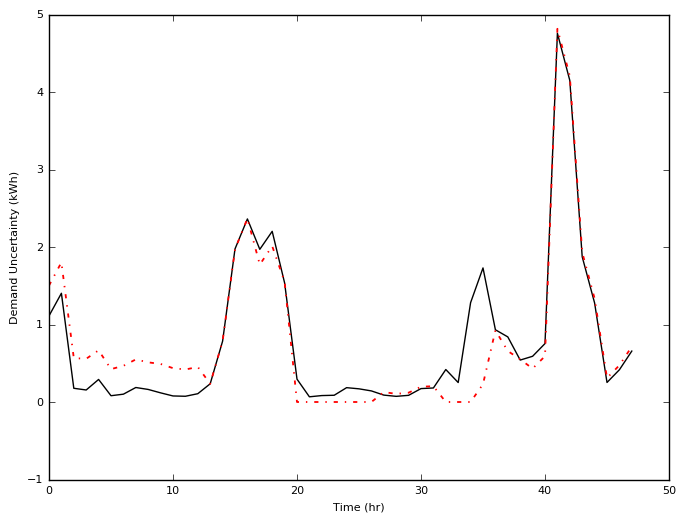

In [19]:
plt.rc('font', family='serif')

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(1, 1, 1)
ax.set_xlabel('The x values')
ax.set_ylabel('The y values')
plt.rc('font', family = 'serif', serif = 'Times')
plt.rc('xtick', labelsize = 8)
plt.rc('ytick', labelsize = 8)
plt.rc('axes', labelsize = 8)

x = range(48)
ax.plot(x, demand0, color='black', ls='solid', linewidth = 1)
ax.plot(x, demand0 + res.x, color='r', ls='dashdot', linewidth = 1.3)
ax.set_xlabel('Time (hr)')
ax.set_ylabel('Demand Uncertainty (kWh)')
plt.show()